In [1]:
# change the following to %matplotlib notebook for interactive plotting
%matplotlib inline

import numpy as np
import pandas as pd

import pims
import trackpy as tp
import os

import matplotlib  as mpl 
import matplotlib.pyplot as plt 

import skimage
import skimage.measure
import matplotlib.patches as mpatches

from scipy import ndimage
from skimage import morphology, util, filters

import tifffile


# Optionally, tweak styles.
mpl.rc('figure',  figsize=(10, 6))
mpl.rc('image', cmap='gray')

### Load image stack

In [19]:
# load tiff stake with pims. Notice here I only have two channels, gfp and cy5
#Burst /Volumes/SL_2023/0313/droplet_different_low_MT_6_8_2_burst

frames = pims.ImageSequence('/Users/scliu/Dropbox (Personal)/Academics/PhD_phase/Thomson_Lab/flow_paper/data/translation/bead_translation_3_bar/Pos0/*.tif')
video = pims.Video('/Users/scliu/Dropbox (Personal)/Academics/PhD_phase/Thomson_Lab/flow_paper/data/avi/3_bar_translation_bead_bf.avi')

Frame([[101, 103, 100, ..., 101, 106,  99],
       [105, 100, 104, ..., 105, 114, 100],
       [108, 104, 104, ..., 106,  98, 109],
       ...,
       [193, 235, 177, ..., 213, 247, 252],
       [182, 207, 212, ..., 208, 201, 213],
       [197, 195, 211, ..., 193, 224, 197]], dtype=uint16)
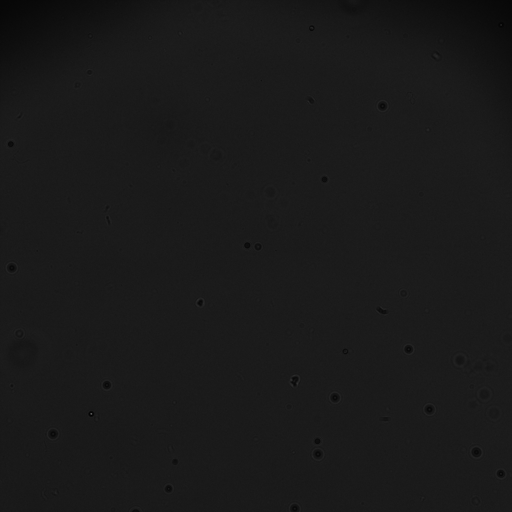

In [20]:
# only want the bf frame
bf_frames = frames[::3]
bf_frames[1]

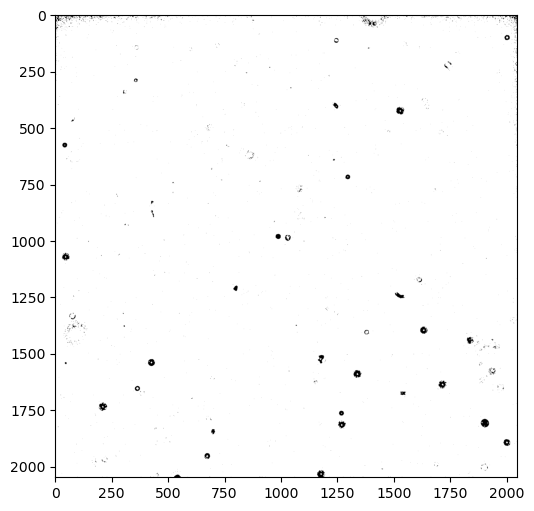

In [4]:
@pims.pipeline
def preprocess_foam(img):
    """
    Apply image processing functions to return a binary image
    """
    # Crop the pictures as for raw images.
    # Apply thresholds
    adaptive_thresh = filters.threshold_local(img,301)
    idx = img < adaptive_thresh
    idx2 = img > adaptive_thresh
    img[idx] = 0
    img[idx2] = 255
    img = ndimage.binary_dilation(img)
    img = ndimage.binary_dilation(img)
    return util.img_as_int(img)


frames_thresh = preprocess_foam(bf_frames)
plt.imshow(frames_thresh[1]);

Found 2295 features


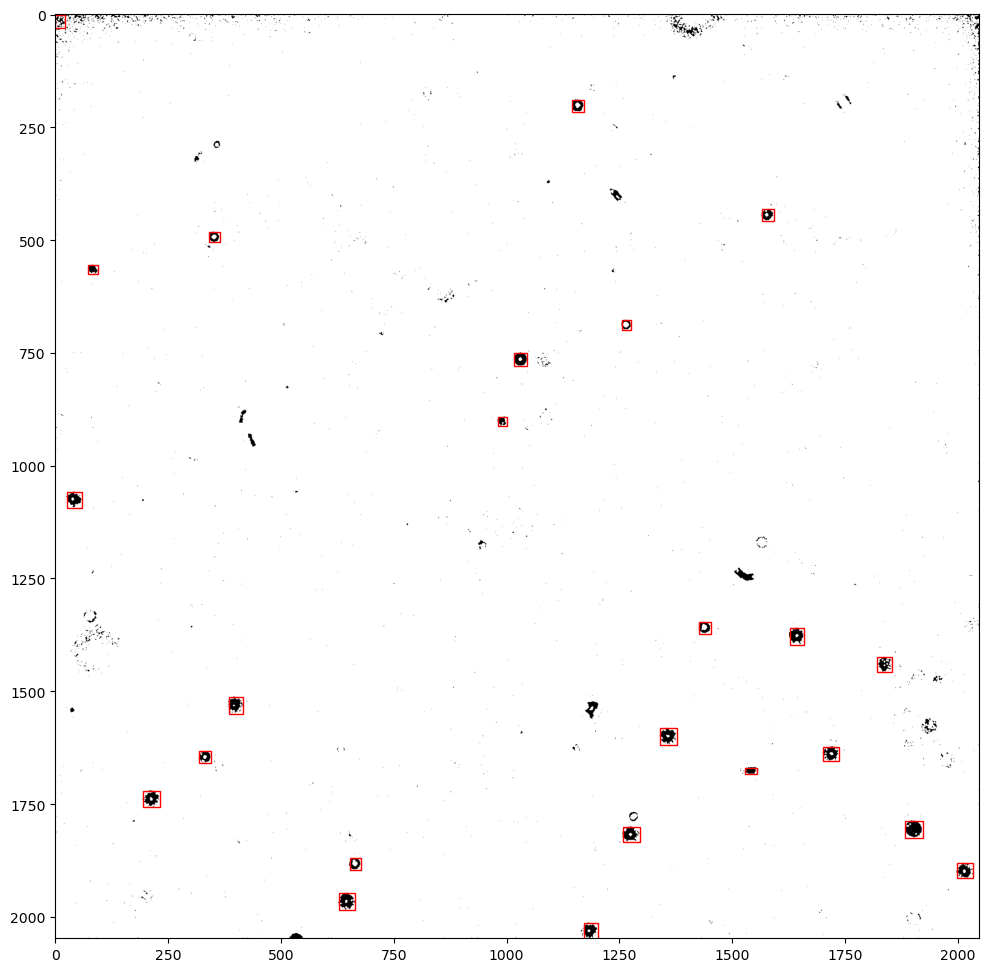

In [5]:
img_example = frames_thresh[24]

# Label elements on the picture
white = 255
label_image, number_of_labels = skimage.measure.label(img_example, background=white, return_num=True)
print("Found %d features"%(number_of_labels))
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12, 12))
ax.imshow(img_example)
for region in skimage.measure.regionprops(label_image, intensity_image=img_example):
    # Everywhere, skip small and large areas
    if region.area < 200 or region.area > 1000:
        continue
    # Only black areas
    if region.mean_intensity > 1:
        continue
    # On the top, skip small area with a second threshold
    if region.centroid[0] > 1000 and region.area < 200:
        continue
    # Skip non-rounded features using eccentricity
    max_eccentricity = 0.8  # Adjust this threshold as needed
    if region.eccentricity > max_eccentricity:
        continue

    # Draw rectangle which survived to the criterions
    minr, minc, maxr, maxc = region.bbox
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                              fill=False, edgecolor='red', linewidth=1)

    ax.add_patch(rect)

In [6]:

def filter_regions(num, img):
    white = 255
    label_image = skimage.measure.label(img, background=white)
    regions = skimage.measure.regionprops(label_image, intensity_image=img)

    filtered_regions = [
        {
            'y': region.centroid[0],
            'x': region.centroid[1],
            'frame': num
        }
        for region in regions
        if (
            200 <= region.area <= 1000 and
            region.mean_intensity <= 1 and
            not (region.centroid[0] > 1000 and region.area < 200) and
            region.eccentricity <= 0.8
        )
    ]

    return filtered_regions


filtered_regions_list = [filter_regions(num, img) for num, img in enumerate(frames_thresh)]
features = pd.DataFrame([item for sublist in filtered_regions_list for item in sublist])


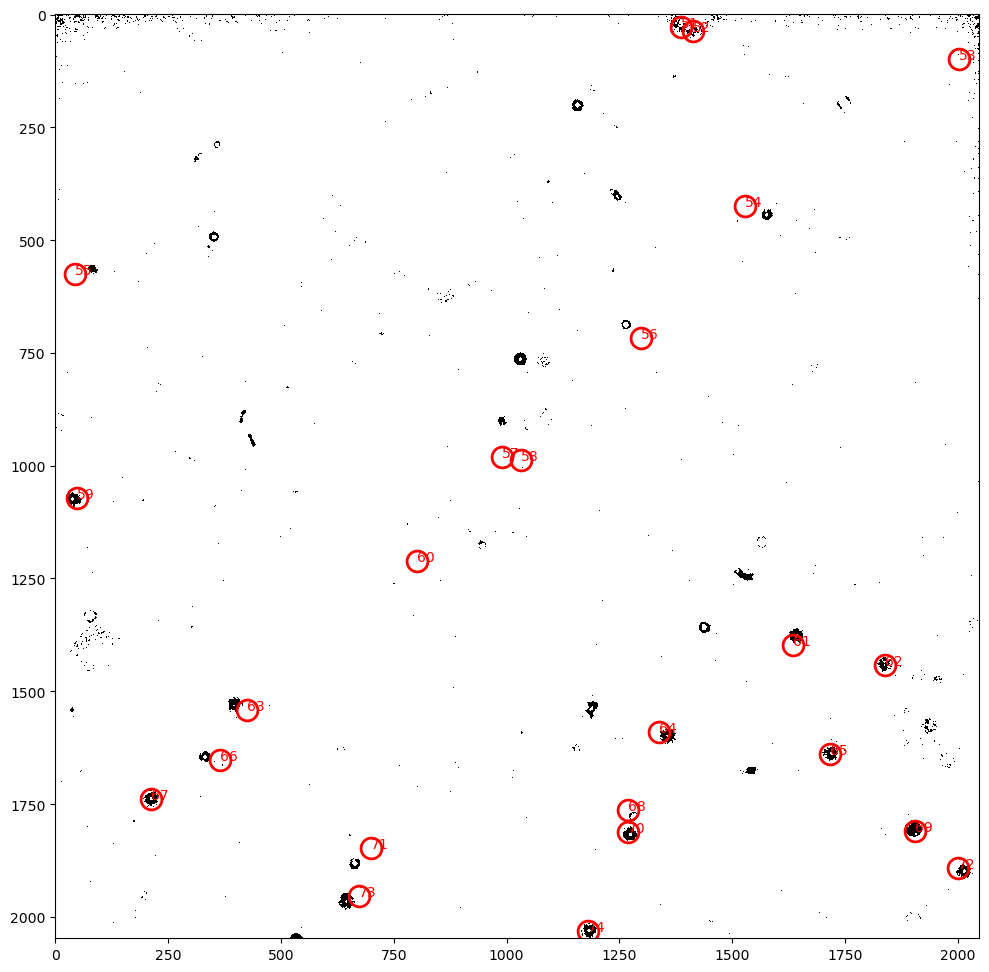

In [7]:
def plot_features_with_labels(frame, features_df, image):
    """
    This function annotates each detected feature with its ID on the plot.

    Parameters:
    frame: The number of the frame you want to plot.
    features_df: A pandas DataFrame that contains the features detected by trackpy.
    image: The image you want to plot the features on.
    """
    # Create a new DataFrame that only contains the features in the frame you're interested in
    frame_features = features_df[features_df.frame==frame]
    
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(image)
    tp.annotate(frame_features, image, ax=ax)
    
    # Annotate the ID of each feature
    for index, feature in frame_features.iterrows():
        ax.text(feature.x, feature.y, str(index), color='red')

    plt.show()


# Then you would use it like this:
id_example = 1
plot_features_with_labels(id_example+1, features, img_example)


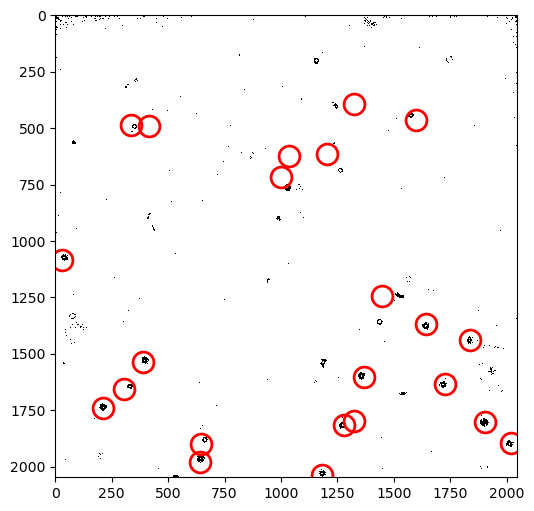

In [8]:
id_example = 50
tp.annotate(features[features.frame==(id_example+1)], img_example);


Frame 299: 20 trajectories present.


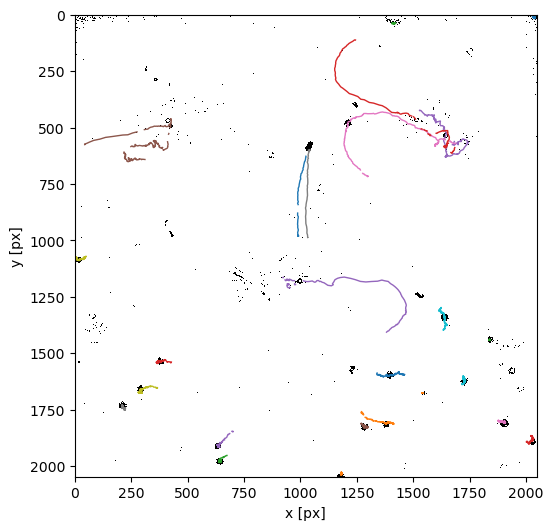

<Axes: xlabel='x [px]', ylabel='y [px]'>

In [9]:
search_range = 50
t = tp.link_df(features, search_range, memory=50)
t1 = tp.filter_stubs(t, threshold=66)

tp.plot_traj(t1, superimpose=frames_thresh[100])

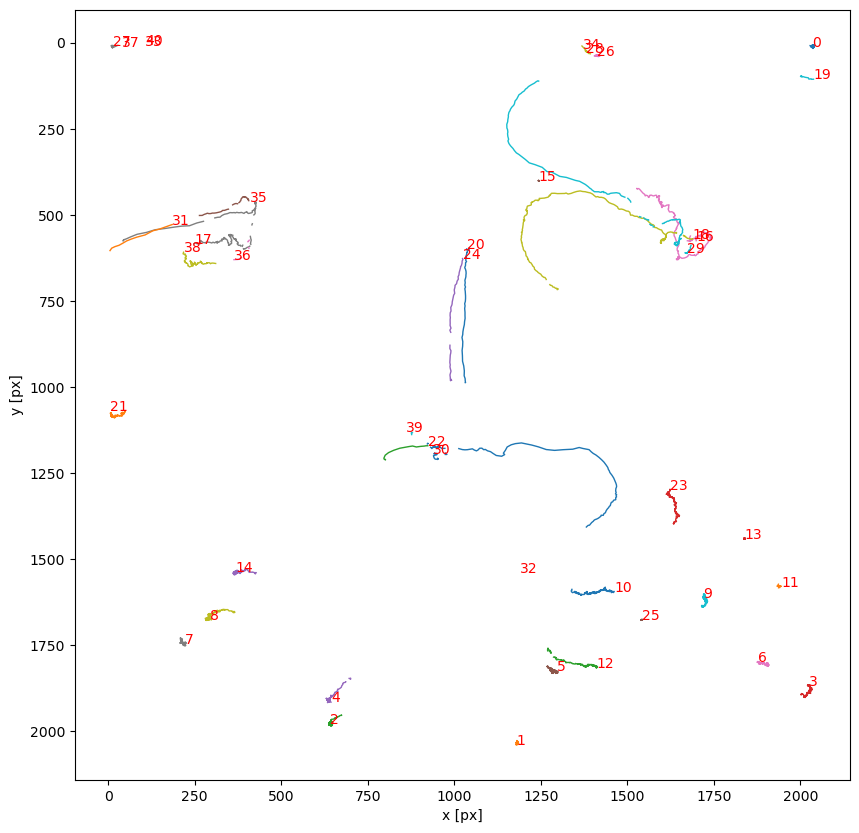

In [10]:
def plot_trajectory_with_labels(particles_df):
    """
    This function plots the trajectories of particles and annotates each one with its ID.

    Parameters:
    particles_df: A pandas DataFrame that contains the particles identified by trackpy.
    """
    fig, ax = plt.subplots(figsize=(10, 10))
    tp.plot_traj(particles_df, ax=ax)

    # Get the last position of each particle to place the text
    last_positions = particles_df.groupby('particle').last()

    # Annotate the ID of each particle
    for particle, position in last_positions.iterrows():
        ax.text(position.x, position.y, str(int(particle)), color='red')

    plt.show()

# Then you would use it like this:
plot_trajectory_with_labels(t)


In [11]:
particle_ids = [24]  # Replace with the IDs of the particles you want to plot
selected = t[t['particle'].isin([20, 24])]
part_20 = t[t['particle'].isin([20])]

# Filter rows where particle is 24 and index is between 50 and 60
filtered_df = selected[(selected['particle'] == 24) & (selected.index >= 50) & (selected.index <= 65)]

# Print the filtered dataframe
print(filtered_df)

             y          x  frame  particle
57  981.794344  989.62982      2        24


In [12]:
# New rows to add
new_rows = [
    {'y': 886.1, 'x': 987.42, 'frame': 28, 'particle': 24},
    {'y': 877.3, 'x': 988.1, 'frame': 29, 'particle': 24},
    {'y': 864.87, 'x': 988.3, 'frame': 30, 'particle': 24},
    {'y': 852.3, 'x': 988.6, 'frame': 31, 'particle': 24}
]

# Add new rows to the dataframe
df = selected.append(new_rows, ignore_index=True)

# Display the updated dataframe
print(df)

              y            x  frame  particle
0    987.023729  1032.149153      0        20
1    977.819951   988.924574      0        24
2    981.115479   988.941032      1        24
3    987.810398  1031.565749      1        20
4    986.564304  1032.023622      2        20
..          ...          ...    ...       ...
137  599.115000  1035.517000     80        20
138  886.100000   987.420000     28        24
139  877.300000   988.100000     29        24
140  864.870000   988.300000     30        24
141  852.300000   988.600000     31        24

[142 rows x 4 columns]


/var/folders/p3/mdh493ks43l04slykq6gwbx80000gn/T/ipykernel_60958/765275466.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = selected.append(new_rows, ignore_index=True)


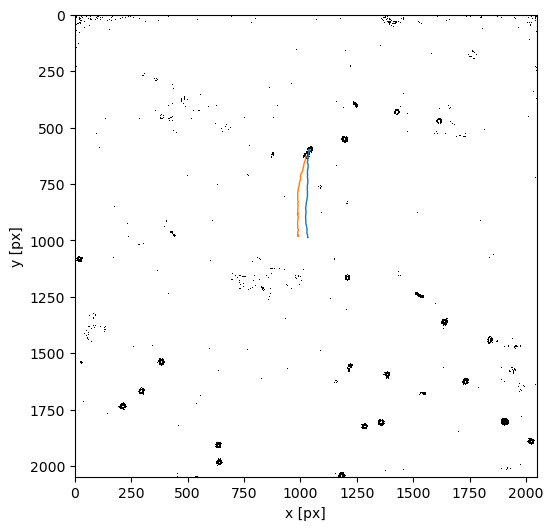

<Axes: xlabel='x [px]', ylabel='y [px]'>

In [13]:
tp.plot_traj(df, superimpose=frames_thresh[70])


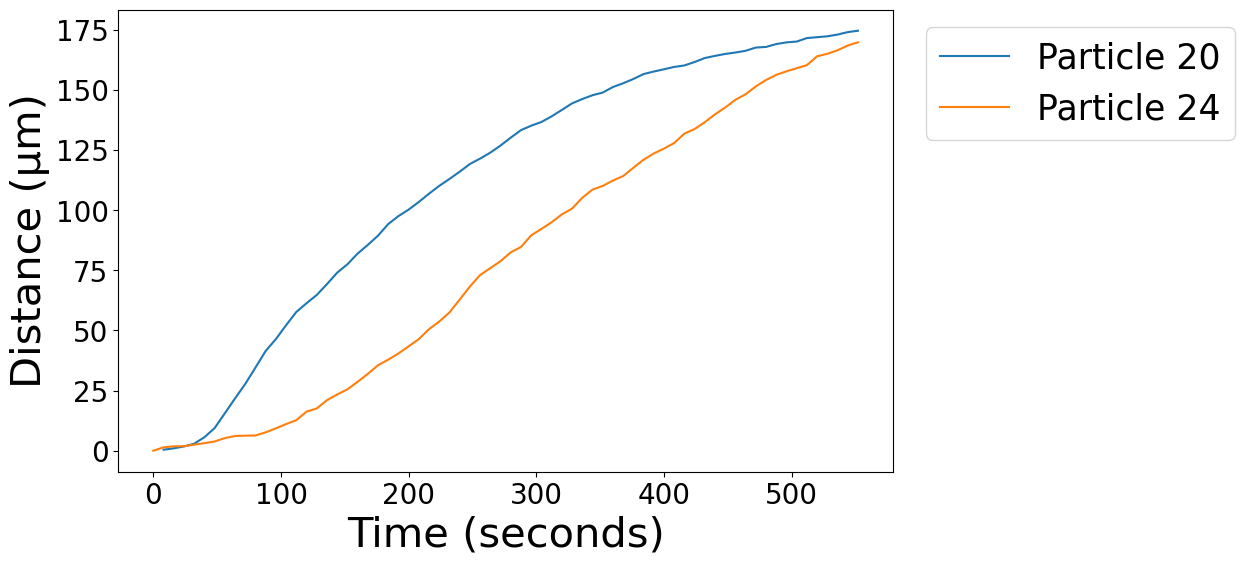

In [14]:
# Sort the dataframe by particle and frame number
df_sorted = df.sort_values(['particle', 'frame'])

# Calculate distance traveled for each particle
df_sorted['distance'] = np.sqrt((df_sorted['x'].diff())**2 + (df_sorted['y'].diff())**2)
df_sorted['distance'] = df_sorted.groupby('particle')['distance'].cumsum()

# Adjust distance for particle 24 to start from 0
df_sorted.loc[df_sorted['particle'] == 24, 'distance'] -= df_sorted.loc[df_sorted['particle'] == 24, 'distance'].iloc[0]

# Convert distance to micrometers
df_sorted['distance'] *= 0.4300668

# Filter dataframe for particles 20 and 24 and up to frame 69
particle_20 = df_sorted[(df_sorted['particle'] == 20) & (df_sorted['frame'] <= 69)]
particle_24 = df_sorted[(df_sorted['particle'] == 24) & (df_sorted['frame'] <= 69)]

# Convert frame number to time in seconds
time_20 = particle_20['frame'] * 8
time_24 = particle_24['frame'] * 8

# Plot total distance traveled for particle 20
plt.plot(time_20, particle_20['distance'], label='Particle 20')

# Plot total distance traveled for particle 24
plt.plot(time_24, particle_24['distance'], label='Particle 24')

plt.xlabel('Time (seconds)', fontsize=30)
plt.ylabel('Distance (µm)', fontsize=30)
plt.legend(fontsize=25, bbox_to_anchor=(1.02, 1), loc='upper left')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.show()


In [15]:
def plot_and_save_trajectory(frame_num, t, frames, save_path, dpi=300):
    fig, ax = plt.subplots()
    t_current = t.loc[t['frame'] <= frame_num]
    tp.plot_traj(t_current, superimpose=frames[frame_num], ax=ax)
    fig.savefig(save_path.format(frame_num), dpi=dpi, bbox_inches='tight')
    plt.close(fig)

In [21]:
save_path = '/Users/scliu/Dropbox (Personal)/Academics/PhD_phase/Thomson_Lab/flow_paper/data/analysis/3_bar_beads_translation_bf/frame_{}.png'
num_frames = len(frames_thresh)

for i in range(69):
    plot_and_save_trajectory(i, df, video, save_path)
